## 1.03 Interpolated radar data analysis - II. Cross sections
___
This notebook first reads in QC-ed cartesian NEXRAD grid, performs polygonization of the Zdr and Kdp fields to locate size sorting areas.
We then generate line-perpendicular cross sections which contain these size sorting areas. These cross section examples can be used to discuss relationships between low-level radar size sorting signatures and their associated microphysical characteristics. 

In [2]:
import pyart 
import numpy as np
import pandas as pd
import warnings
import xarray
from siphon.simplewebservice.iastate import IAStateUpperAir
import matplotlib.pyplot as plt
import seaborn as sns
warnings.filterwarnings(action='ignore',category=DeprecationWarning)
warnings.filterwarnings(action='ignore',category=RuntimeWarning)
warnings.filterwarnings(action='ignore',category=FutureWarning)
from datetime import datetime
import glob, os
import auto_filter,snr_noise,attenuation,calc_kdp,tools,retrieval,echo_classification
import gridrad_homeyer
import proplot as plot
from skimage import measure
from labellines import labelLine, labelLines
plot.rc.update({'figure.facecolor': 'w','font.name':'Helvetica','axes.labelweight':'ultralight',
                'tick.labelweight':'ultralight','gridminor.linestyle':'--','title.weight':'normal','linewidth':0.5})

In [3]:
# Setting relevant paths
#-------------------------------------------------------------------------------------------------
input_gridpath = '/scra6/ft21894/radartrunk/0605/PID/0500-0700/'
radargridlist = sorted(glob.glob(input_gridpath+'KTWX_KEAX_20150605_*.nc')) #KABR_KFSD
input_gridrad = sorted(glob.glob('/scra6/ft21894/radartrunk/NEXRAD_mosaic/0620_plot/'+'*.nc'))
#Bowman, K. P., and C. R. Homeyer. 2017. (cite:https://rda.ucar.edu/datasets/ds841.0/)

# Read in grid files and save data time
#-------------------------------------------------------------------------------------------------
base = pyart.io.read_grid(radargridlist[0]) #0620b:10 0701:4 0706:0,8 0617:11;7,19 (LNX),
base.fields.keys()
dt = datetime.strptime(base.time['units'][-20:], '%Y-%m-%dT%H:%M:%SZ')

/scra6/ft21894/anaconda3/lib/python3.7/site-packages/pyart/io/grid_io.py:107: UserWarning: Field alt skipped due to incorrect shape (1,)
  % (field, bad_shape))
/scra6/ft21894/anaconda3/lib/python3.7/site-packages/pyart/io/grid_io.py:107: UserWarning: Field lat skipped due to incorrect shape (1,)
  % (field, bad_shape))
/scra6/ft21894/anaconda3/lib/python3.7/site-packages/pyart/io/grid_io.py:107: UserWarning: Field lon skipped due to incorrect shape (1,)
  % (field, bad_shape))


### Load RAP analysis field

In [4]:
rap_analysis = xarray.open_dataset('/scra6/ft21894/radartrunk/RAP/15071303.rap.t03z.awp130bgrbf00.nc')
UGRD_P0_L105_GLC0 = rap_analysis['UGRD_P0_L105_GLC0']
VGRD_P0_L105_GLC0 = rap_analysis['VGRD_P0_L105_GLC0']
HGT_P0_L105_GLC0 = rap_analysis['HGT_P0_L105_GLC0']
gridlat_0,gridlon_0 = rap_analysis['gridlat_0'],rap_analysis['gridlon_0']
radargrid_lon,radargrid_lat = base.get_point_longitude_latitude(level=2)

In [4]:
def cmap_map(function, cmap):
    """ Applies function (which should operate on vectors of shape 3: [r, g, b]), on colormap cmap.
    This routine will break any discontinuous points in a colormap.
    """
    import matplotlib
    cdict = cmap._segmentdata
    step_dict = {}
    # Firt get the list of points where the segments start or end
    for key in ('red', 'green', 'blue'):
        step_dict[key] = list(map(lambda x: x[0], cdict[key]))
    step_list = sum(step_dict.values(), [])
    step_list = np.array(list(set(step_list)))
    # Then compute the LUT, and apply the function to the LUT
    reduced_cmap = lambda step : np.array(cmap(step)[0:3])
    old_LUT = np.array(list(map(reduced_cmap, step_list)))
    new_LUT = np.array(list(map(function, old_LUT)))
    # Now try to make a minimal segment definition of the new LUT
    cdict = {}
    for i, key in enumerate(['red','green','blue']):
        this_cdict = {}
        for j, step in enumerate(step_list):
            if step in step_dict[key]:
                this_cdict[step] = new_LUT[j, i]
            elif new_LUT[j,i] != old_LUT[j, i]:
                this_cdict[step] = new_LUT[j, i]
        colorvector = list(map(lambda x: x + (x[1], ), this_cdict.items()))
        colorvector.sort()
        cdict[key] = colorvector

    return matplotlib.colors.LinearSegmentedColormap('colormap',cdict,1024)

import cartopy.io.img_tiles as cimgt
import io
from urllib.request import urlopen, Request
from PIL import Image
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.ticker as mticker
import matplotlib
import pyart.graph.cm as pyartcm
from cartopy.io.shapereader import Reader
from cartopy.feature import ShapelyFeature
import cartopy.feature as feature
from matplotlib.axes import Axes
from cartopy.mpl.geoaxes import GeoAxes
import cartopy.mpl.ticker as cticker
from scipy.ndimage.filters import gaussian_filter
import seaborn as sns
import matplotlib.font_manager as fm
import cartopy.crs as crs
import cartopy_set
from shapely import geometry
GeoAxes._pcolormesh_patched = Axes.pcolormesh

def add_sub_region_box(ax, subregion,facecolor='none',edgecolor='r',linewidth=2.3):
    """ """
    geom = geometry.box(minx=subregion[0],maxx=subregion[1],miny=subregion[2],maxy=subregion[3])
    ax.add_geometries([geom], crs=crs.PlateCarree(), facecolor=facecolor,edgecolor=edgecolor,linewidth=linewidth)
    return ax

from matplotlib.patches import PathPatch
from matplotlib.path import Path
import matplotlib.pyplot as plt
from shapely.geometry.point import Point
from shapely import geometry

def make_polygon(TYPE='square',loc=None,dist=10,mgrid=np.mgrid[0:350+1,0:400+1],rapindex=None,
                 rapmgrid=np.mgrid[0:336+1,0:450+1]):
    """
    loc: [y_begin,y_end,x_begin,x_end] as defined in the figure!
    """
    if TYPE=='square':
        raddeg = (np.arctan2(np.abs(loc[1]-loc[0]),np.abs(loc[3]-loc[2])))
        upleft,upright = [np.round(loc[2]+dist*np.sin(raddeg)),np.round(loc[0]+dist*np.cos(raddeg))],\
        [np.round(loc[3]+dist*np.sin(raddeg)),np.round(loc[1]+dist*np.cos(raddeg))]
        downleft,downright = [np.round(loc[2]-dist*np.sin(raddeg)),np.round(loc[0]-dist*np.cos(raddeg))],\
        [np.round(loc[3]-dist*np.sin(raddeg)),np.round(loc[1]-dist*np.cos(raddeg))]
        
        pointList = [Point(upleft[0],upleft[1]),Point(upright[0],upright[1]),\
                     Point(downright[0],downright[1]),Point(downleft[0],downleft[1])]
        polygon = geometry.Polygon([[p.x,p.y] for p in pointList])
        
        y,x=mgrid
        coordlist = np.vstack((list(polygon.exterior.coords.xy[0]), list(polygon.exterior.coords.xy[1]))).T
        coord_map = np.vstack((x.flatten(), y.flatten())).T
        polypath = Path(coordlist)
        mask = polypath.contains_points(coord_map).reshape(x.shape)
        return polypath,mask,upleft,upright,downleft,downright,raddeg
    elif TYPE=='Reanalysis':
        pointList = [Point(rapindex[0][0],rapindex[0][1]),Point(rapindex[1][0],rapindex[1][1]),\
                     Point(rapindex[2][0],rapindex[2][1]),Point(rapindex[3][0],rapindex[3][1])]
        polygon = geometry.Polygon([[p.x,p.y] for p in pointList])
        y,x=rapmgrid
        coordlist = np.vstack((list(polygon.exterior.coords.xy[0]), list(polygon.exterior.coords.xy[1]))).T
        coord_map = np.vstack((x.flatten(), y.flatten())).T
        polypath = Path(coordlist)
        mask = polypath.contains_points(coord_map).reshape(x.shape)
        return polygon,polypath,mask

def make_envpolygon(TYPE='square',raddeg=None,upright=None,downright=None,dist=100,mgrid=np.mgrid[0:350+1,0:400+1],
                   rap_index=None,rapmgrid=np.mgrid[0:336+1,0:450+1]):
    """
    loc: [y_begin,y_end,x_begin,x_end] as defined in the figure!
    """
    from copy import deepcopy
    if TYPE=='square':
        newupleft,newupright = deepcopy(upright),\
        [np.round(upright[0]+dist*np.cos(raddeg)),np.round(upright[1]-dist*np.sin(raddeg))]
        newdownleft,newdownright = deepcopy(downright),\
        [np.round(downright[0]+dist*np.cos(raddeg)),np.round(downright[1]-dist*np.sin(raddeg))]
        
        pointList = [Point(newupleft[0],newupleft[1]),Point(newupright[0],newupright[1]),\
                     Point(newdownright[0],newdownright[1]),Point(newdownleft[0],newdownleft[1])]
        polygon = geometry.Polygon([[p.x,p.y] for p in pointList])
        
        y,x=mgrid
        coordlist = np.vstack((list(polygon.exterior.coords.xy[0]), list(polygon.exterior.coords.xy[1]))).T
        coord_map = np.vstack((x.flatten(), y.flatten())).T
        polypath = Path(coordlist)
        mask = polypath.contains_points(coord_map).reshape(x.shape)
    return polypath,mask,newupleft,newupright,newdownleft,newdownright
    #elif TYPE=='Reanalysis':
    #    newupleft,newupright = deepcopy(rap_index[0]),

def adjust_spines(ax, spines,offset=10):
    for loc, spine in ax.spines.items():
        if loc in spines:
            spine.set_position(('outward', offset))  # outward by 10 points
        else:
            spine.set_color('None')  # don't draw spine

    # turn off ticks where there is no spine
    if 'left' in spines:
        ax.yaxis.set_ticks_position('left')
    else:
        # no yaxis ticks
        ax.yaxis.set_ticks([])

    if 'bottom' in spines:
        ax.xaxis.set_ticks_position('bottom')
    else:
        # no xaxis ticks
        ax.xaxis.set_ticks([])

def polygonize2(array=None,amplitude_filter=None,size_filter=None,method='centroid',amplitude_num=None):
    """
    (1) Use scikit-image to identify contours
    (2) Use shapely to calculate centroid coordinate
    """
    from shapely.geometry import Polygon
    if amplitude_num is None:
        contours = measure.find_contours(array,np.nanpercentile(array[array>0],amplitude_filter))
    else:
        contours = measure.find_contours(array,amplitude_num)
    
    dict_area = []
    for contour in contours:
        if len(contour)<3: #Filter small objects
            dict_area.append(0)
        else:
            polygon=Polygon(contour)
            dict_area.append(polygon.area)
            
    large_objectindex = np.where(np.asarray(dict_area)>np.percentile(np.asarray(dict_area),size_filter))
    centroid_obj,centroid_objkdp = [],[]
    for obj in np.squeeze(large_objectindex):
        polygon_temp = Polygon(contours[obj])
        if method=='centroid':
            centroid_obj.append(polygon_temp.centroid.coords)
        elif method=='representative_point':
            centroid_obj.append(polygon_temp.representative_point().coords)
    return contours,centroid_obj,dict_area

In [5]:
#polypath,mask,upleft,upright,downleft,downright,raddeg = make_polygon(TYPE='square',
#                                                               loc=[225+9,80+9,210+28,230+20],dist=10,
#                                                               mgrid=np.mgrid[0:350+1,0:400+1])
#polypath2,mask2,upleft2,upright2,downleft2,downright2,raddeg2 = make_polygon(TYPE='square',
#                                                               loc=[150,55,160-1,180-1],dist=10,
#                                                               mgrid=np.mgrid[0:350+1,0:400+1])
# Test (0504)
polypath,mask,upleft,upright,downleft,downright,raddeg = make_polygon(TYPE='square',
                                                               loc=[300,145,95-2,112-2],dist=10,
                                                               mgrid=np.mgrid[0:350+1,0:400+1])
#[225,80,210,230][95-2,112-2],[300,145]

#### Find Zdr, Kdp contours

In [22]:
from scipy.ndimage import gaussian_filter

base = pyart.io.read_grid(radargridlist[2])
index = 2
conv_zdr = gaussian_filter(base.fields['zdr_acorr']['data'][index,:,:],0.77)
conv_zdr[gaussian_filter(base.fields['cross_correlation_ratio']['data'][index,:,:],0.77)<0.95] = 0
conv_zdr[gaussian_filter(base.fields['reflectivity']['data'][index,:,:],0.77)<30] = 0
conv_kdp = gaussian_filter(base.fields['KDP']['data'][index,:,:],0.67)
conv_kdp[gaussian_filter(base.fields['cross_correlation_ratio']['data'][index,:,:],0.67)<0.95] = 0
conv_kdp[gaussian_filter(base.fields['reflectivity']['data'][index,:,:],0.67)<30] = 0

cntr_zdrt,cntrd_zdrt,_ = polygonize2(array=conv_zdr[:,:],amplitude_filter=93,
                                     size_filter=65,method='centroid',amplitude_num=3.1)
cntr_kdpt,cntrd_kdpt,_ = polygonize2(array=conv_kdp[:,:],amplitude_filter=95,
                                     size_filter=65,method='centroid',amplitude_num=None)

/scra6/ft21894/anaconda3/lib/python3.7/site-packages/pyart/io/grid_io.py:107: UserWarning: Field alt skipped due to incorrect shape (1,)
  % (field, bad_shape))
/scra6/ft21894/anaconda3/lib/python3.7/site-packages/pyart/io/grid_io.py:107: UserWarning: Field lat skipped due to incorrect shape (1,)
  % (field, bad_shape))
/scra6/ft21894/anaconda3/lib/python3.7/site-packages/pyart/io/grid_io.py:107: UserWarning: Field lon skipped due to incorrect shape (1,)
  % (field, bad_shape))


In [23]:
from copy import deepcopy
dist_vect = []
for objz in cntrd_zdrt:
    tmp = [((obj.xy[1][0]-objz.xy[1][0])**2+(obj.xy[0][0]-objz.xy[0][0])**2)**(0.5) for obj in cntrd_kdpt]
    dist_vect.append(tmp)

cntr_zdrtc,cntrd_zdrtc = deepcopy(cntr_zdrt),deepcopy(cntrd_zdrt)
for index,value in enumerate(dist_vect):
    if all(element>25 for element in value):
        cntr_zdrtc[index]=np.nan
        cntrd_zdrtc[index]=np.nan
        dist_vect[index] = np.nan

zdrkdp_xdist,zdrkdp_ydist = [],[]
for index,zdrc in enumerate(cntrd_zdrtc):
    if np.isnan(zdrc).any():
        zdrkdp_xdist.append(np.nan)
        zdrkdp_ydist.append(np.nan)
    else:
        zdrc_x,zdrc_y = zdrc[0][1],zdrc[0][0]
        tmp_x,tmp_y = [(-obj.xy[1][0]+zdrc_x) for obj in cntrd_kdpt],\
        [(-obj.xy[0][0]+zdrc_y) for obj in cntrd_kdpt]
        zdrkdp_xdist.append(tmp_x)
        zdrkdp_ydist.append(tmp_y)

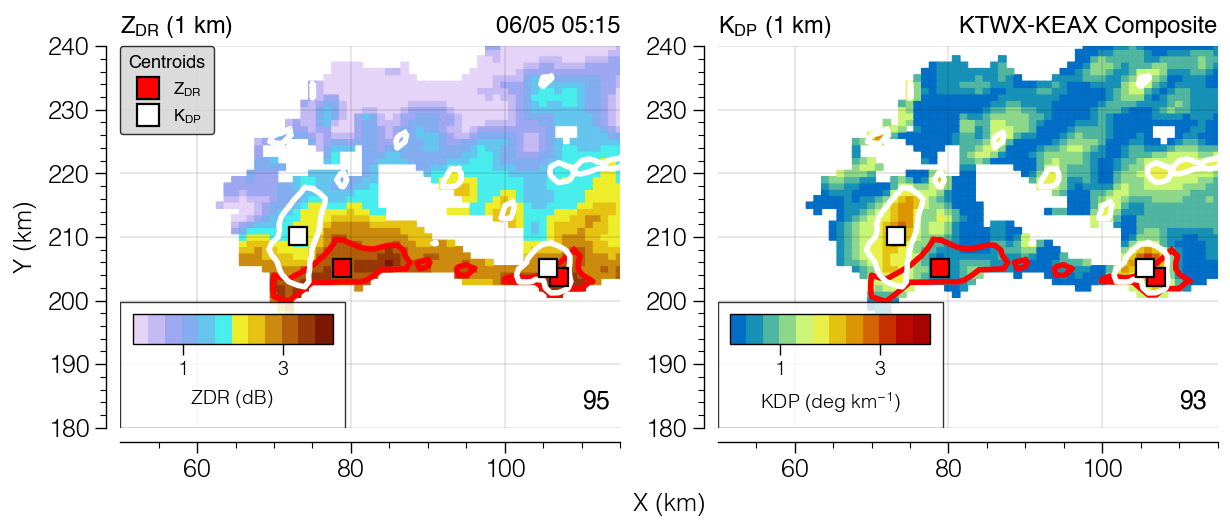

In [57]:
from scipy.ndimage.filters import gaussian_filter
import matplotlib.lines as mlines
fig, axs = plot.subplots(ncols=2,nrows=1,share=2, axwidth=2.5,aspect=1.31)
cntr1 = axs[0].pcolormesh(np.ma.masked_equal(conv_zdr,0),
                                             cmap =cmap_map(lambda x: x, pyart.graph.cm.LangRainbow12),
                  levels=np.linspace(0,4,13),shading='auto',alpha=0.99,antialiased=True)
axs[0].colorbar(cntr1, loc="ll", label="ZDR (dB)",ticks=[1,3],ticklabelsize=7,labelsize=7)
axs[0].text(110,183,'95',fontweight='medium',color='k') 
for contour in cntr_zdrt:
    if np.isnan(contour).all():
        continue
    else:
        axs[0].plot(contour[:, 1], contour[:, 0], linewidth=2,color='r')
for contour in cntr_kdpt:
    axs[0].plot(contour[:, 1], contour[:, 0], linewidth=2,color='w')
for i,obj in enumerate(cntrd_zdrt):
    if np.isnan(obj).all():
        continue
    else:
        axs[0].plot(obj.xy[1][0], obj.xy[0][0], linewidth=0,color='r',marker='s',markeredgecolor='k',markeredgewidth=0.8,
            markersize=6.75)
for i,obj in enumerate(cntrd_kdpt):
    axs[0].plot(obj.xy[1][0], obj.xy[0][0], linewidth=0,color='w',marker='s',markeredgecolor='k',markeredgewidth=0.8,
            markersize=6.75)
    
h1 = mlines.Line2D([], [], color='r', marker='s', markeredgecolor='k',markeredgewidth=0.8,linestyle=None,linewidth=0,
                   markersize=8)
h2 = mlines.Line2D([], [], color='w', marker='s', markeredgecolor='k',markeredgewidth=0.8,linestyle=None,linewidth=0,
                   markersize=8)
LEGD = axs[0].legend([h1,h2], ['Z$_{DR}$','K$_{DP}$'],frameon=True, fancybox=True, shadow=False, loc=1, 
                     ncol=1,facecolor='lightgray',prop={"size":6})
LEGD.set_title('Centroids',prop={"size":6.5})
#axs[0].plot([95-2,112-2],[300,145],lw=2,c='g',alpha=0.90)
#patch = PathPatch(polypath, facecolor='green', alpha=.35)
#axs[0].add_patch(patch)
axs[0].format(xlim=[50,115],ylim=[180,240],xgridminor=False,ygrid=True,xgrid=True,
              ylabel='Y (km)',xlabel='X (km)',
              ltitle=r'Z$_{DR}$ (1 km)', rtitle='06/05 05:15',titlesize=8.5)
adjust_spines(axs[0], ['left','bottom'],5)
for label in axs[0].get_xticklabels():
    label.set_fontweight('light')
for label in axs[0].get_yticklabels():
    label.set_fontweight('light')
    
cntr1 = axs[1].pcolormesh(np.ma.masked_equal(conv_kdp,0),
                          cmap =cmap_map(lambda x: x, pyart.graph.cm_colorblind.HomeyerRainbow),
                  levels=np.linspace(0,4,13),shading='auto',alpha=0.99,antialiased=True)
axs[1].colorbar(cntr1, loc="ll", label=r"KDP (deg km$^{-1}$)",ticks=[1,3],ticklabelsize=7,labelsize=7)

for contour in cntr_zdrt:
    if np.isnan(contour).all():
        continue
    else:
        axs[1].plot(contour[:, 1], contour[:, 0], linewidth=2,color='r')
for contour in cntr_kdpt:
    axs[1].plot(contour[:, 1], contour[:, 0], linewidth=2,color='w')
for i,obj in enumerate(cntrd_zdrt):
    if np.isnan(obj).all():
        continue
    else:
        axs[1].plot(obj.xy[1][0], obj.xy[0][0], linewidth=0,color='r',marker='s',markeredgecolor='k',markeredgewidth=0.8,
            markersize=6.75)
for i,obj in enumerate(cntrd_kdpt):
    axs[1].plot(obj.xy[1][0], obj.xy[0][0], linewidth=0,color='w',marker='s',markeredgecolor='k',markeredgewidth=0.8,
            markersize=6.75)
axs[1].format(xlim=[50,115],ylim=[180,240],xgridminor=False,ygrid=True,xgrid=True,
              ylabel='Y (km)',xlabel='X (km)',
              ltitle=r'K$_{DP}$ (1 km)', rtitle='KTWX-KEAX Composite',titlesize=8.5)
adjust_spines(axs[1], ['left','bottom'],5)
for label in axs[1].get_xticklabels():
    label.set_fontweight('light')
for label in axs[1].get_yticklabels():
    label.set_fontweight('light')
axs[1].text(110,183,'93',fontweight='medium',color='k')    
plt.show()

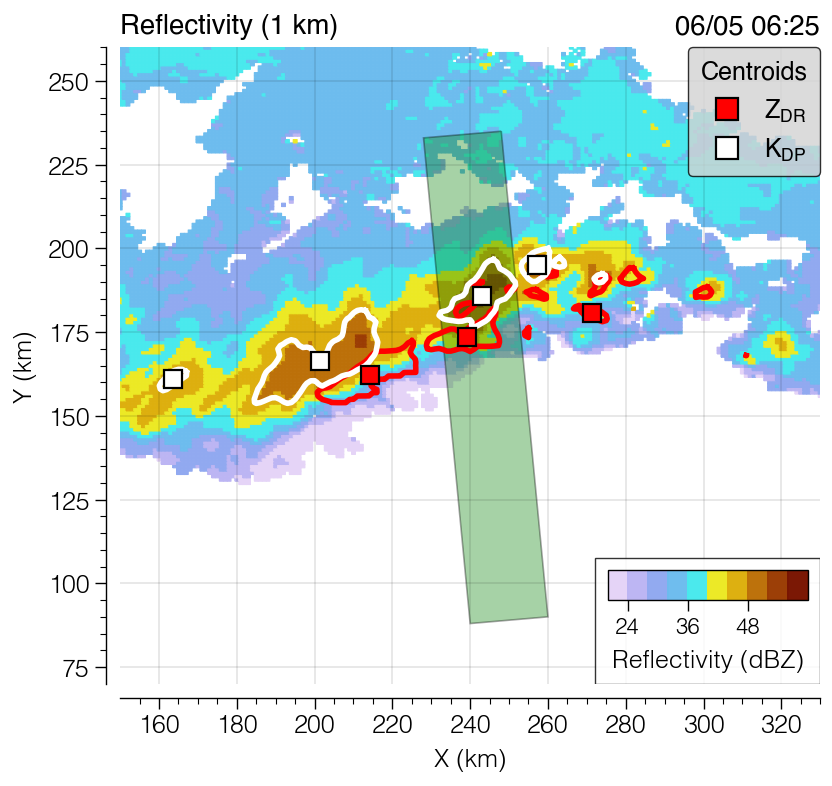

In [17]:
from scipy.ndimage.filters import gaussian_filter
import matplotlib.lines as mlines
fig, axs = plot.subplots(ncols=1,nrows=1,share=0, axwidth=3.5,aspect=1.1)
cntr1 = axs[0].pcolormesh(np.ma.masked_less(base.fields['reflectivity']['data'][2,:,:],10),
                                             cmap =cmap_map(lambda x: x, pyart.graph.cm.LangRainbow12),
                  vmin=20,vmax=60,shading='auto',alpha=0.99,antialiased=True)
axs[0].colorbar(cntr1, loc="lr", label="Reflectivity (dBZ)",ticks=[24,36,48],ticklabelsize=8)

for contour in cntr_zdrt:
    if np.isnan(contour).all():
        continue
    else:
        axs[0].plot(contour[:, 1], contour[:, 0], linewidth=2,color='r')
for contour in cntr_kdpt:
    axs[0].plot(contour[:, 1], contour[:, 0], linewidth=2,color='w')
for i,obj in enumerate(cntrd_zdrt):
    if np.isnan(obj).all():
        continue
    else:
        axs[0].plot(obj.xy[1][0], obj.xy[0][0], linewidth=0,color='r',marker='s',markeredgecolor='k',markeredgewidth=0.8,
            markersize=6.75)
for i,obj in enumerate(cntrd_kdpt):
    axs[0].plot(obj.xy[1][0], obj.xy[0][0], linewidth=0,color='w',marker='s',markeredgecolor='k',markeredgewidth=0.8,
            markersize=6.75)
    
h1 = mlines.Line2D([], [], color='r', marker='s', markeredgecolor='k',markeredgewidth=0.8,linestyle=None,linewidth=0,
                   markersize=8)
h2 = mlines.Line2D([], [], color='w', marker='s', markeredgecolor='k',markeredgewidth=0.8,linestyle=None,linewidth=0,
                   markersize=8)
LEGD = axs[0].legend([h1,h2], ['Z$_{DR}$','K$_{DP}$'],frameon=True, fancybox=True, shadow=False, loc=1, 
                     ncol=1,facecolor='lightgray')
LEGD.set_title('Centroids')
#axs[0].plot([210+28,230+20],[225+9,80+9],lw=2,c='g',alpha=0.90)
patch = PathPatch(polypath, facecolor='green', alpha=.35)
axs[0].add_patch(patch)
axs[0].format(xlim=[150,330],ylim=[70,260],xgridminor=False,ygrid=True,xgrid=True,
              ylabel='Y (km)',xlabel='X (km)',
              ltitle='Reflectivity (1 km)', rtitle='06/05 06:25')
adjust_spines(axs[0], ['left','bottom'],5)
for label in axs[0].get_xticklabels():
    label.set_fontweight('light')
for label in axs[0].get_yticklabels():
    label.set_fontweight('light')
plt.show()

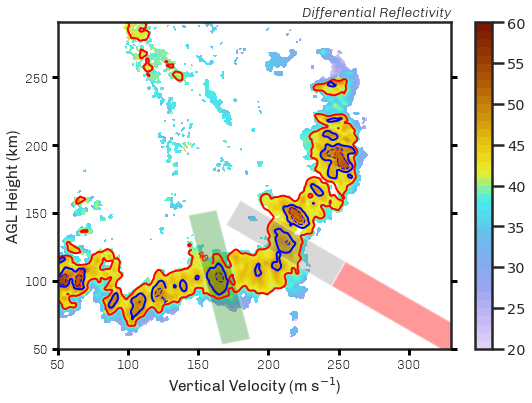

In [27]:
fig = plt.figure(figsize=(8.8,6))

# plot super resolution reflectivity
ax = fig.add_subplot(111)
a = plt.contourf(np.ma.masked_less(np.ma.masked_where(base.fields['zdr_acorr']['data'][2,:,:]<0,
                                      base.fields['reflectivity']['data'][2,:,:]),20),
                   levels=np.linspace(20,60,41),cmap='pyart_LangRainbow12')
#a = plt.contourf(#np.ma.masked_where(base.fields['zdr_acorr']['data'][2,:,:]<0.01,
#                                      (base.fields['reflectivity']['data'][2,:,:]),
#                   levels=np.linspace(0,60,15),cmap='pyart_LangRainbow12')
a1 = plt.contour(gaussian_filter(base.fields['reflectivity']['data'][2,:,:],0.87),
            levels=[40],linewidths=2,colors='r')
plt.contour(gaussian_filter(base.fields['reflectivity']['data'][2,:,:],0.87),
            levels=[50],linewidths=1,colors='r',linestyles='--')
a3 = plt.contour(gaussian_filter(base.fields['KDP']['data'][2,:,:],0.97),
            levels=[1],linewidths=2,colors='b')
plt.contour(gaussian_filter(base.fields['KDP']['data'][2,:,:],0.97),
            levels=[1.75],linewidths=1,colors='b',linestyles='--')
patch = PathPatch(polypath, facecolor='gray', alpha=.3)
ax.add_patch(patch)
patch2 = PathPatch(polypath2, facecolor='green', alpha=.3)
ax.add_patch(patch2)
patchENV = PathPatch(polypathENV, facecolor='red', alpha=.4)
ax.add_patch(patchENV)
txt1 = ax.clabel(a1, inline=0.0001, fmt='%1.0f',fontsize=9,manual=[(155,120)])
txt2 = ax.clabel(a3, inline=1e-10, fmt='%1.0f',manual=[(130,75)])
for l in txt1+txt2:
    l.set_fontproperties(fm.FontProperties(fname='/scra6/ft21894/anaconda3/font/Chivo/ttf/Chivo-Medium.ttf',size=10))
plt.colorbar(a)
plt.xlim(50,330)
plt.ylim(50,230+60)
#ax.plot([175,250],[160-10,115-10],lw=3,c='k')
#ax.plot([153,177],[150,55],lw=3,c='g')
#ax.plot([y_left[0],y_right[0]],[x_left[0],x_right[0]],lw=2,c='k',linestyle='--')
#ax.plot([downleft[0],downright[0]],[downleft[1],downright[1]],lw=2,c='k',linestyle='--')
#ax.set_yticks([50,100,150,200])
for label in ax.get_yticklabels():
    label.set_fontproperties(fm.FontProperties(fname='/scra6/ft21894/anaconda3/font/Chivo/ttf/Chivo-Thin.ttf',size=12.5))
#ax.set_xticks([80,120,160,200])
for label in ax.get_xticklabels():
    label.set_fontproperties(fm.FontProperties(fname='/scra6/ft21894/anaconda3/font/Chivo/ttf/Chivo-Thin.ttf',size=12.5))
ax.tick_params(axis='both',which='major',direction='out',length=6,width=3,colors='k',right=True,left=True,bottom=True)
ax.spines['top'].set_linewidth(2.5)
ax.spines['left'].set_linewidth(2.5)
ax.spines['right'].set_linewidth(2.5)
ax.spines['bottom'].set_linewidth(2.5)
ax.set_ylabel('AGL Height (km)',fontproperties=prop,fontsize=15.5)
ax.set_xlabel('Vertical Velocity (m s$^{-1}$)',fontproperties=prop,fontsize=15.5)
#plt.title('06/20-07/01',fontproperties=prop,loc='left',fontsize=15.03)
plt.title('Differential Reflectivity',
          fontproperties=fm.FontProperties(fname='/scra6/ft21894/anaconda3/font/Chivo/ttf/Chivo-LightItalic.ttf'),loc='right',
         fontsize=14.03)
plt.show()

### Cross sections

In [9]:
from siphon.simplewebservice.iastate import IAStateUpperAir
from datetime import datetime
date_name = datetime(2015,6,3,0)
station_name = 'KTOP' #KOAX
df0620 = IAStateUpperAir.request_data(date_name,station_name)
df0620_nonan = df0620.dropna()
#T0620,z0620 = tools.interpolate_sounding_to_radar(df0620.dropna(),base)
#T0620b,z0620b = tools.interpolate_sounding_to_radar(df0620.dropna(),base2)

In [14]:
np.abs(df0620['temperature']-0).argmin(),df0620['height'][np.abs(df0620['temperature']-0).argmin()]

(24, 4251.0)

In [11]:
from copy import deepcopy
import skimage.measure as measure
def make_boxcrosssection(var_name=None,met_x=None,met_y=None,upleft=None,upright=None,downleft=None,downright=None):
    x_left,y_left = measure.profile_line(met_x,[downleft[0],downleft[1]],[upleft[0],upleft[1]]),\
    measure.profile_line(met_y,[downleft[0],downleft[1]],[upleft[0],upleft[1]])
    x_right,y_right = measure.profile_line(met_x,[downright[0],downright[1]],[upright[0],upright[1]]),\
    measure.profile_line(met_y,[downright[0],downright[1]],[upright[0],upright[1]])
    
    ref = []
    for i in range(len(base.fields[var_name]['data'][:,0,0])):
        a = deepcopy(base.fields[var_name]['data'][i,:,:])
        a[a<0] = np.nan
        temp = np.nanmean(np.asarray([measure.profile_line(np.ma.masked_less(a,0),[x_left[i],y_left[i]],
                                                           [x_right[i],y_right[i]],
                                                           mode='reflect') for i in range(len(x_left))]),axis=0)
        ref.append(temp)
        del a,temp
    return np.asarray(ref)

def make_boxcrosssection_array(var=None,met_x=None,met_y=None,upleft=None,upright=None,downleft=None,downright=None):
    x_left,y_left = measure.profile_line(met_x,[downleft[0],downleft[1]],[upleft[0],upleft[1]]),\
    measure.profile_line(met_y,[downleft[0],downleft[1]],[upleft[0],upleft[1]])
    x_right,y_right = measure.profile_line(met_x,[downright[0],downright[1]],[upright[0],upright[1]]),\
    measure.profile_line(met_y,[downright[0],downright[1]],[upright[0],upright[1]])
    
    ref = []
    for i in range(len(var[:,0,0])):
        a = deepcopy(var[i,:,:])
        a[a<0] = np.nan
        temp = np.nanmean(np.asarray([measure.profile_line(np.ma.masked_less(a,0),[x_left[i],y_left[i]],
                                                           [x_right[i],y_right[i]],
                                                           mode='reflect') for i in range(len(x_left))]),axis=0)
        ref.append(temp)
        del a,temp
    return np.asarray(ref)

/scra6/ft21894/anaconda3/lib/python3.7/site-packages/proplot/figure.py:1158: MatplotlibDeprecationWarning: The 'extend' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  return super().colorbar(*args, cax=cax, **kwargs)


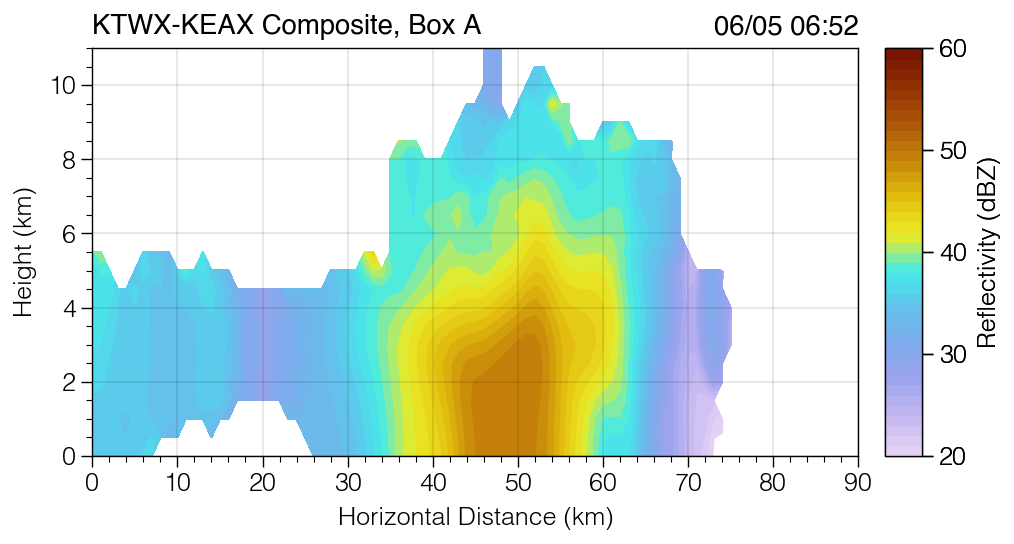

In [20]:
y,x = np.mgrid[0:400+1,0:400+1]
z = deepcopy(base.z['data'])
a = make_boxcrosssection(var_name='reflectivity',met_x=x,met_y=y,
                              upleft=upleft,upright=upright,downleft=downleft,downright=downright)
fig, axs = plot.subplots(ncols=1,share=0, axwidth=3.83,aspect=1.88,wspace='10pt')
shd1=axs[0].contourf(np.linspace(0,a.shape[1]-1,a.shape[1]),z[0:41]/1000,np.ma.masked_less(a,0),
                     cmap=cmap_map(lambda x: x*0.989, pyart.graph.cm.LangRainbow12),levels=np.linspace(20,60,41))
cbar = axs[0].colorbar(shd1, loc="r", label="Reflectivity (dBZ)",ticks=[20,30,40,50,60])
for label in cbar.ax.get_yticklabels():
    label.set_fontweight('light')
axs[0].format(xlim=[0,90],xgridminor=False,ylim=[0,11],yticks=[0,2,4,6,8,10],ylabel='Height (km)',
              xlabel='Horizontal Distance (km)',ltitle='KTWX-KEAX Composite, Box A', rtitle='06/05 06:52') 
plt.show()

/scra6/ft21894/anaconda3/lib/python3.7/site-packages/proplot/figure.py:1158: MatplotlibDeprecationWarning: The 'extend' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  return super().colorbar(*args, cax=cax, **kwargs)


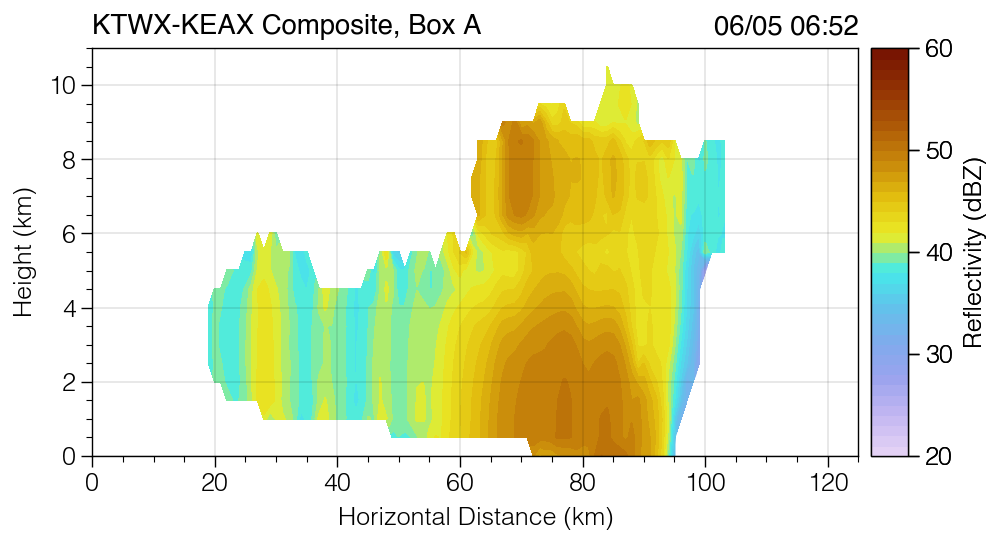

In [12]:
y,x = np.mgrid[0:400+1,0:400+1]
z = deepcopy(base.z['data'])
a = make_boxcrosssection(var_name='reflectivity',met_x=x,met_y=y,
                              upleft=upleft,upright=upright,downleft=downleft,downright=downright)
fig, axs = plot.subplots(ncols=1,share=0, axwidth=3.83,aspect=1.88,wspace='10pt')
shd1=axs[0].contourf(np.linspace(0,a.shape[1]-1,a.shape[1]),z[0:41]/1000,np.ma.masked_less(a,0),
                     cmap=cmap_map(lambda x: x*0.989, pyart.graph.cm.LangRainbow12),levels=np.linspace(20,60,41))
cbar = axs[0].colorbar(shd1, loc="r", label="Reflectivity (dBZ)",ticks=[20,30,40,50,60])
for label in cbar.ax.get_yticklabels():
    label.set_fontweight('light')
axs[0].format(xlim=[0,125],xgridminor=False,ylim=[0,11],yticks=[0,2,4,6,8,10],ylabel='Height (km)',
              xlabel='Horizontal Distance (km)',ltitle='KTWX-KEAX Composite, Box A', rtitle='06/05 06:52') 
plt.show()

/scra6/ft21894/anaconda3/lib/python3.7/site-packages/proplot/figure.py:1158: MatplotlibDeprecationWarning: The 'extend' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  return super().colorbar(*args, cax=cax, **kwargs)
/scra6/ft21894/anaconda3/lib/python3.7/site-packages/proplot/figure.py:1158: MatplotlibDeprecationWarning: The 'extend' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  return super().colorbar(*args, cax=cax, **kwargs)


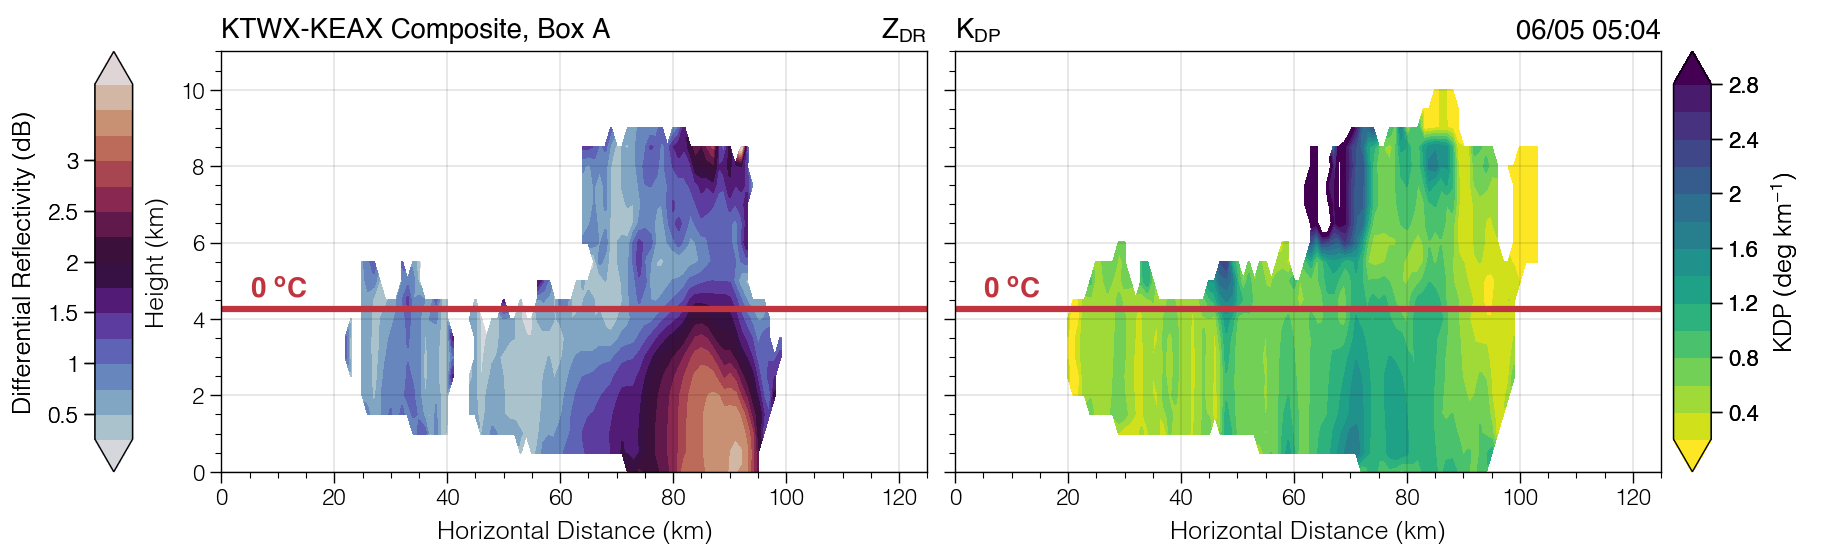

In [41]:
a = make_boxcrosssection(var_name='KDP',met_x=x,met_y=y,
                              upleft=upleft,upright=upright,downleft=downleft,downright=downright)
b = make_boxcrosssection(var_name='zdr_acorr',met_x=x,met_y=y,
                              upleft=upleft,upright=upright,downleft=downleft,downright=downright)
plot.rc.update({'figure.facecolor': 'w','font.name':'Helvetica','axes.labelweight':'ultralight',
                'tick.labelweight':'ultralight','gridminor.linestyle':'--','title.weight':'normal','linewidth':0.5,
               'tick.labelsize':8})

fig, axs = plot.subplots(ncols=2,share=0, axwidth=3.53,aspect=1.68,wspace='10pt')
kwargs = {'xlim':[0,125],'xgridminor':False,'ylim':[0,11],'yticks':[0,2,4,6,8,10],
              'xlabel':'Horizontal Distance (km)',}
shd1=axs[0].contourf(np.linspace(0,a.shape[1]-1,a.shape[1]),z[0:41]/1000,np.ma.masked_less(b,0),
                     cmap='twilight',levels=np.linspace(0,4,17))
cntr2=axs[0].plot([0,125],[4.251,4.251],color='#bf343f',lw=2.25)
axs[0].text(5, 4.61, '0 $^{o}$C', color='#bf343f', rotation=0, rotation_mode='anchor',size=10,weight='bold')
axs[0].colorbar(shd1, loc="l", label="Differential Reflectivity (dB)",ticks=[0,0.5,1,1.5,2,2.5,3],extend='both')
axs[0].format(**kwargs,ylabel='Height (km)',ltitle='KTWX-KEAX Composite, Box A', rtitle='Z$_{DR}$') 
shd1=axs[1].contourf(np.linspace(0,a.shape[1]-1,a.shape[1]),z[0:41]/1000,np.ma.masked_less(a,0),
                     cmap='viridis_r',levels=np.linspace(0,3,16))
cntr2=axs[1].plot([0,125],[4.251,4.251],color='#bf343f',lw=2.25)
axs[1].text(5, 4.61, '0 $^{o}$C', color='#bf343f', rotation=0, rotation_mode='anchor',size=10,weight='bold')
axs[1].colorbar(shd1, loc="r", label="KDP (deg km$^{-1}$)",extend='both',ticks=[0.4,0.8,1.2,1.6,2,2.4,2.8])
axs[1].format(**kwargs, ltitle='K$_{DP}$',rtitle='06/05 05:04')
axs[1].set_yticklabels('')
plt.show()
#for label in cbar.ax.get_yticklabels():
#    label.set_fontweight('light')

In [25]:
np.nanpercentile(c,80),np.nanpercentile(d,80)

(0.6999237537384033, 0.7541107058525087)

/scra6/ft21894/anaconda3/lib/python3.7/site-packages/proplot/figure.py:1158: MatplotlibDeprecationWarning: The 'extend' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  return super().colorbar(*args, cax=cax, **kwargs)
/scra6/ft21894/anaconda3/lib/python3.7/site-packages/proplot/figure.py:1158: MatplotlibDeprecationWarning: The 'extend' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  return super().colorbar(*args, cax=cax, **kwargs)


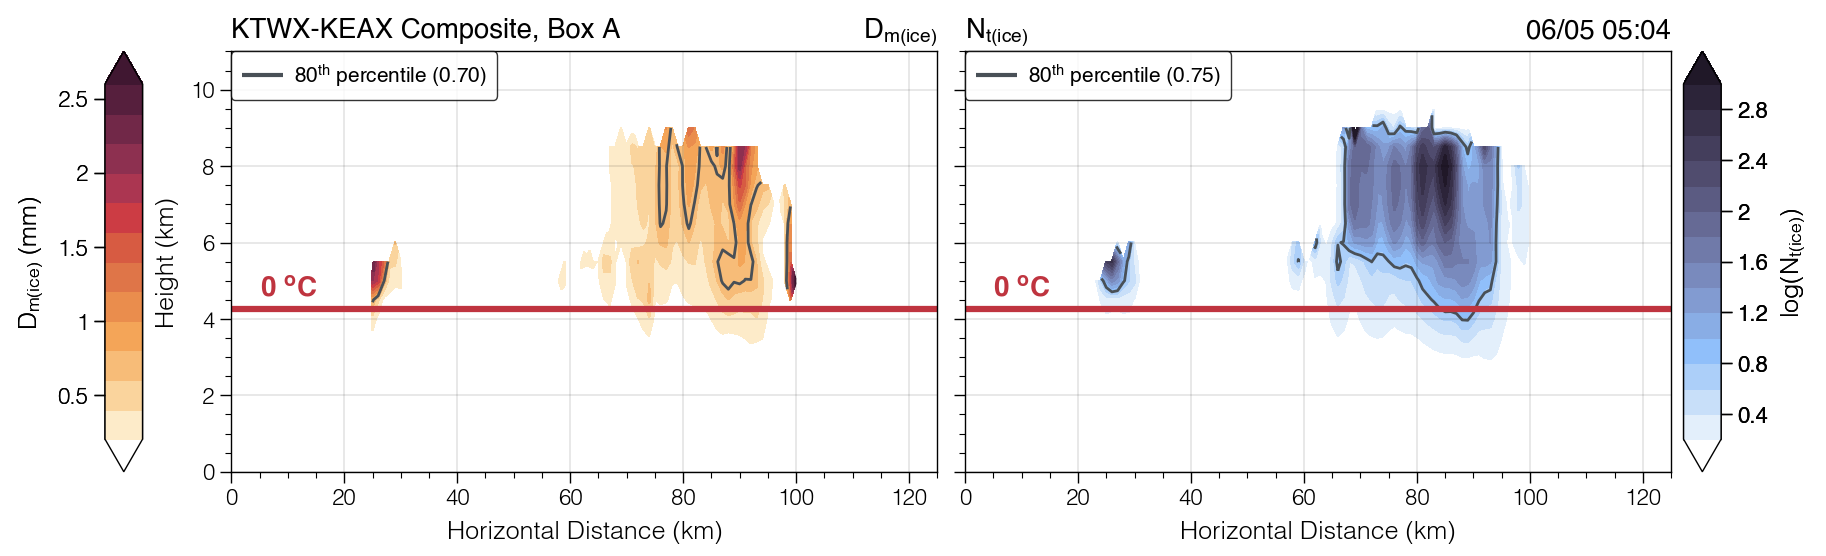

In [44]:
c = make_boxcrosssection(var_name='Dm_ice',met_x=x,met_y=y,
                              upleft=upleft,upright=upright,downleft=downleft,downright=downright)
d = make_boxcrosssection(var_name='Nt_ice',met_x=x,met_y=y,
                              upleft=upleft,upright=upright,downleft=downleft,downright=downright)
fig, axs = plot.subplots(ncols=2,share=0, axwidth=3.53,aspect=1.68,wspace='10pt')
kwargs = {'xlim':[0,125],'xgridminor':False,'ylim':[0,11],'yticks':[0,2,4,6,8,10],
              'xlabel':'Horizontal Distance (km)',}
shd1=axs[0].contourf(np.linspace(0,a.shape[1]-1,a.shape[1]),z[0:41]/1000,np.ma.masked_less(c,0),
                     cmap='fire',levels=np.linspace(0,2.8,15))
per1=axs[0].contour(np.linspace(0,a.shape[1]-1,a.shape[1]),z[0:41]/1000,np.ma.masked_less(c,0),
                     color='gray7',levels=[0.7],labels=False, lw=1, 
                    labels_kw={'weight': 'bold','size':7,'inline':False},precision=1)
cntr2=axs[0].plot([0,125],[4.251,4.251],color='#bf343f',lw=2.25)
h1 = mlines.Line2D([], [], color='gray7')
LEGD = axs[0].legend([h1], ['80$^{th}$ percentile (0.70)'],frameon=True, fancybox=True, shadow=False, loc=2, 
                     ncol=1,prop={'size': 7.5})
axs[0].text(5, 4.61, '0 $^{o}$C', color='#bf343f', rotation=0, rotation_mode='anchor',size=10,weight='bold')
axs[0].colorbar(shd1, loc="l", label="D$_{m (ice)}$ (mm)",ticks=[0,0.5,1,1.5,2,2.5,3],extend='both')
axs[0].format(**kwargs,ylabel='Height (km)',ltitle='KTWX-KEAX Composite, Box A', rtitle='D$_{m (ice)}$') 

shd1=axs[1].contourf(np.linspace(0,a.shape[1]-1,a.shape[1]),z[0:41]/1000,np.ma.masked_less(d,0),
                     cmap='dusk',levels=np.linspace(0,3.2,17))
per2=axs[1].contour(np.linspace(0,a.shape[1]-1,a.shape[1]),z[0:41]/1000,np.ma.masked_less(d,0),
                     color='gray7',levels=[0.75],labels=False, lw=1, 
                    labels_kw={'weight': 'bold','size':7,'inline':False},precision=1)
cntr2=axs[1].plot([0,125],[4.251,4.251],color='#bf343f',lw=2.25)
h1 = mlines.Line2D([], [], color='gray7')
LEGD = axs[1].legend([h1], ['80$^{th}$ percentile (0.75)'],frameon=True, 
                     fancybox=True, shadow=False, loc=2, ncol=1,prop={'size': 7.5})
axs[1].text(5, 4.61, '0 $^{o}$C', color='#bf343f', rotation=0, rotation_mode='anchor',size=10,weight='bold')
axs[1].colorbar(shd1, loc="r", label="log(N${_{t (ice)}}$)",extend='both',ticks=[0.4,0.8,1.2,1.6,2,2.4,2.8])
axs[1].format(**kwargs, ltitle='N$_{t (ice)}$',rtitle='06/05 05:04')
axs[1].set_yticklabels('')
plt.show()

/scra6/ft21894/anaconda3/lib/python3.7/site-packages/proplot/figure.py:1158: MatplotlibDeprecationWarning: The 'extend' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  return super().colorbar(*args, cax=cax, **kwargs)
/scra6/ft21894/anaconda3/lib/python3.7/site-packages/proplot/figure.py:1158: MatplotlibDeprecationWarning: The 'extend' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  return super().colorbar(*args, cax=cax, **kwargs)


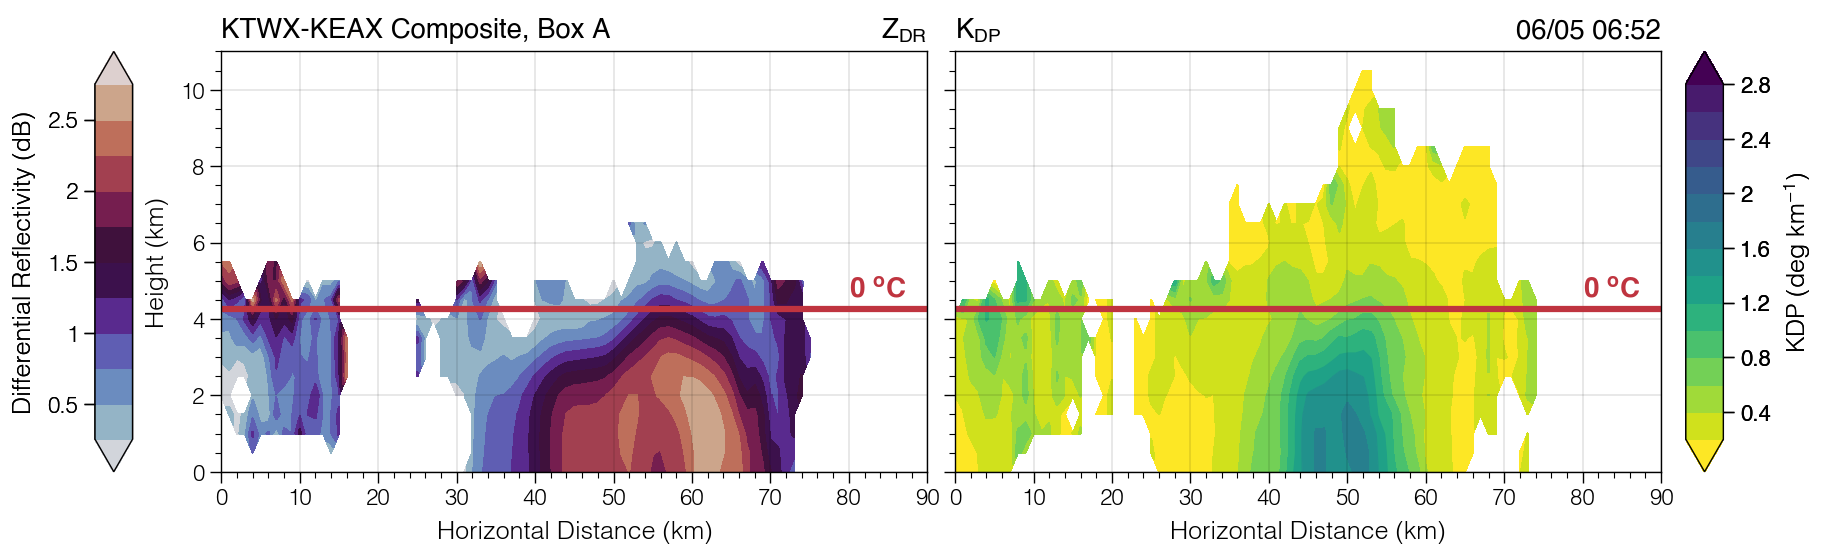

In [23]:
a = make_boxcrosssection(var_name='KDP',met_x=x,met_y=y,
                              upleft=upleft,upright=upright,downleft=downleft,downright=downright)
b = make_boxcrosssection(var_name='zdr_acorr',met_x=x,met_y=y,
                              upleft=upleft,upright=upright,downleft=downleft,downright=downright)
plot.rc.update({'figure.facecolor': 'w','font.name':'Helvetica','axes.labelweight':'ultralight',
                'tick.labelweight':'ultralight','gridminor.linestyle':'--','title.weight':'normal','linewidth':0.5,
               'tick.labelsize':8})

fig, axs = plot.subplots(ncols=2,share=0, axwidth=3.53,aspect=1.68,wspace='10pt')
kwargs = {'xlim':[0,90],'xgridminor':False,'ylim':[0,11],'yticks':[0,2,4,6,8,10],
              'xlabel':'Horizontal Distance (km)',}
shd1=axs[0].contourf(np.linspace(0,a.shape[1]-1,a.shape[1]),z[0:41]/1000,np.ma.masked_less(b,0),
                     cmap='twilight',levels=np.linspace(0,3,13))
cntr2=axs[0].plot([0,120],[4.251,4.251],color='#bf343f',lw=2.25)
axs[0].text(80, 4.61, '0 $^{o}$C', color='#bf343f', rotation=0, rotation_mode='anchor',size=10,weight='bold')
axs[0].colorbar(shd1, loc="l", label="Differential Reflectivity (dB)",ticks=[0,0.5,1,1.5,2,2.5,3],extend='both')
axs[0].format(**kwargs,ylabel='Height (km)',ltitle='KTWX-KEAX Composite, Box A', rtitle='Z$_{DR}$') 
shd1=axs[1].contourf(np.linspace(0,a.shape[1]-1,a.shape[1]),z[0:41]/1000,np.ma.masked_less(a,0),
                     cmap='viridis_r',levels=np.linspace(0,3,16))
cntr2=axs[1].plot([0,120],[4.251,4.251],color='#bf343f',lw=2.25)
axs[1].text(80, 4.61, '0 $^{o}$C', color='#bf343f', rotation=0, rotation_mode='anchor',size=10,weight='bold')
axs[1].colorbar(shd1, loc="r", label="KDP (deg km$^{-1}$)",extend='both',ticks=[0.4,0.8,1.2,1.6,2,2.4,2.8])
axs[1].format(**kwargs, ltitle='K$_{DP}$',rtitle='06/05 06:52')
axs[1].set_yticklabels('')
plt.show()
#for label in cbar.ax.get_yticklabels():
#    label.set_fontweight('light')

/scra6/ft21894/anaconda3/lib/python3.7/site-packages/proplot/figure.py:1158: MatplotlibDeprecationWarning: The 'extend' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  return super().colorbar(*args, cax=cax, **kwargs)


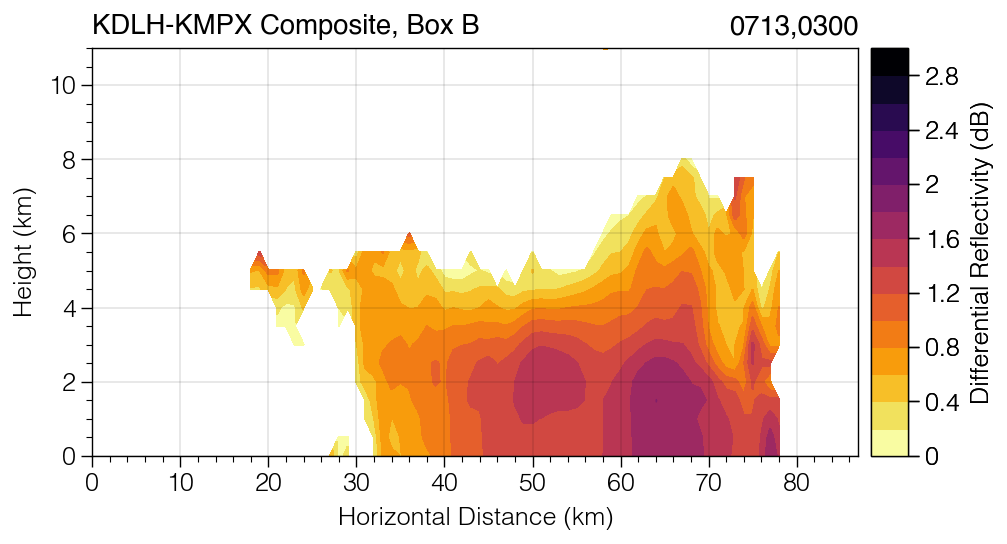

In [61]:
a = make_boxcrosssection(var_name='zdr_acorr',met_x=x,met_y=y,
                              upleft=upleft2,upright=upright2,downleft=downleft2,downright=downright2)
fig, axs = plot.subplots(ncols=1,share=0, axwidth=3.83,aspect=1.88,wspace='10pt')
shd1=axs[0].contourf(np.linspace(0,a.shape[1]-1,a.shape[1]),z[0:41]/1000,np.ma.masked_less(a,0),
                     cmap=cmap_map(lambda x: x*0.989, Inferno_18_r.mpl_colormap),levels=np.linspace(0,3,16))
cbar = axs[0].colorbar(shd1, loc="r", label="Differential Reflectivity (dB)")
for label in cbar.ax.get_yticklabels():
    label.set_fontweight('light')
axs[0].format(xlim=[0,87],xgridminor=False,ylim=[0,11],yticks=[0,2,4,6,8,10],ylabel='Height (km)',
              xlabel='Horizontal Distance (km)',ltitle='KDLH-KMPX Composite, Box B', rtitle='0713,0300') 
plt.show()

In [34]:
polypathENV,maskENV,upleftENV,uprightENV,downleftENV,downrightENV = \
make_envpolygon(TYPE='square',raddeg=raddeg,upright=upright,downright=downright,dist=100,
             mgrid=np.mgrid[0:350+1,0:400+1])
polypathENV2,maskENV2,upleftENV2,uprightENV2,downleftENV2,downrightENV2 = \
make_envpolygon(TYPE='square',raddeg=raddeg2,upright=upright2,downright=downright2,dist=100,
             mgrid=np.mgrid[0:350+1,0:400+1])

def radarind_to_rapind_polygonize(radargrid_ind=[upleftENV,uprightENV,downrightENV,downleftENV],
                                  radarlon=radargrid_lon,radarlat=radargrid_lat,
                                  raplon=np.asarray(gridlon_0),raplat=np.asarray(gridlat_0),TYPE='square'):
    from scipy import spatial
    tree = spatial.KDTree(np.column_stack([np.ravel(raplon), np.ravel(raplat)]))
    
    dist,idx=[],[]
    for i in range(len(radargrid_ind)):
        lon = radarlon[int(radargrid_ind[i][0]),int(radargrid_ind[i][1])]
        lat = radarlat[int(radargrid_ind[i][0]),int(radargrid_ind[i][1])]
        temp1,temp2 = tree.query(np.asarray([lon,lat]))
        dist.append(temp1)
        idx.append(temp2)
    
    rapindex = [np.unravel_index(index,raplon.shape) for index in idx]
    return rapindex

rapindex = radarind_to_rapind_polygonize(radargrid_ind=[upleftENV,downleftENV])
rapindex2 = radarind_to_rapind_polygonize(radargrid_ind=[upleftENV2,downleftENV2])

In [104]:
def make_envpolygon(TYPE='square',raddeg=None,upright=None,downright=None,dist=100,mgrid=np.mgrid[0:350+1,0:400+1],
                   rap_index=None,rapmgrid=np.mgrid[0:336+1,0:450+1],orientation='NW-SE'):
    """
    loc: [y_begin,y_end,x_begin,x_end] as defined in the figure!
    rap_index: upleft,downleft
    """
    from copy import deepcopy
    if orientation=='NW-SE':
        if TYPE=='square':
            newupleft,newupright = deepcopy(upright),\
            [np.round(upright[0]+dist*np.cos(raddeg)),np.round(upright[1]-dist*np.sin(raddeg))]
            newdownleft,newdownright = deepcopy(downright),\
            [np.round(downright[0]+dist*np.cos(raddeg)),np.round(downright[1]-dist*np.sin(raddeg))]
            
            pointList = [Point(newupleft[0],newupleft[1]),Point(newupright[0],newupright[1]),\
                         Point(newdownright[0],newdownright[1]),Point(newdownleft[0],newdownleft[1])]
            polygon = geometry.Polygon([[p.x,p.y] for p in pointList])
            
            y,x=mgrid
            coordlist = np.vstack((list(polygon.exterior.coords.xy[0]), list(polygon.exterior.coords.xy[1]))).T
            coord_map = np.vstack((x.flatten(), y.flatten())).T
            polypath = Path(coordlist)
            mask = polypath.contains_points(coord_map).reshape(x.shape)
            return polypath,mask,newupleft,newupright,newdownleft,newdownright
        elif TYPE=='Reanalysis':
            newupleft,newupright = deepcopy(rap_index[0]),\
            [np.round(rap_index[0][0]+(dist*np.cos(raddeg))/13),np.round(rap_index[0][1]-(dist*np.sin(raddeg))/13)]
            newdownleft,newdownright = deepcopy(rap_index[1]),\
            [np.round(rap_index[1][0]+(dist*np.cos(raddeg))/13),np.round(rap_index[1][1]-(dist*np.sin(raddeg))/13)]
            
            pointList = [Point(newupleft[0],newupleft[1]),Point(newupright[0],newupright[1]),\
                         Point(newdownright[0],newdownright[1]),Point(newdownleft[0],newdownleft[1])]
            polygon = geometry.Polygon([[p.x,p.y] for p in pointList])
            
            y,x=rapmgrid
            coordlist = np.vstack((list(polygon.exterior.coords.xy[0]), list(polygon.exterior.coords.xy[1]))).T
            coord_map = np.vstack((x.flatten(), y.flatten())).T
            polypath = Path(coordlist)
            mask = polypath.contains_points(coord_map).reshape(x.shape)
            return polygon,polypath,mask,newupleft,newupright,newdownleft,newdownright
        
def make_polygon(TYPE='square',loc=None,dist=10,mgrid=np.mgrid[0:350+1,0:400+1],rapindex=None,
                 rapmgrid=np.mgrid[0:336+1,0:450+1],r_circle=5):
    """
    loc: [y_begin,y_end,x_begin,x_end] as defined in the figure!
    """
    if TYPE=='square':
        raddeg = (np.arctan2(np.abs(loc[1]-loc[0]),np.abs(loc[3]-loc[2])))
        upleft,upright = [np.round(loc[2]+dist*np.sin(raddeg)),np.round(loc[0]+dist*np.cos(raddeg))],\
        [np.round(loc[3]+dist*np.sin(raddeg)),np.round(loc[1]+dist*np.cos(raddeg))]
        downleft,downright = [np.round(loc[2]-dist*np.sin(raddeg)),np.round(loc[0]-dist*np.cos(raddeg))],\
        [np.round(loc[3]-dist*np.sin(raddeg)),np.round(loc[1]-dist*np.cos(raddeg))]
        
        pointList = [Point(upleft[0],upleft[1]),Point(upright[0],upright[1]),\
                     Point(downright[0],downright[1]),Point(downleft[0],downleft[1])]
        polygon = geometry.Polygon([[p.x,p.y] for p in pointList])
        
        y,x=mgrid
        coordlist = np.vstack((list(polygon.exterior.coords.xy[0]), list(polygon.exterior.coords.xy[1]))).T
        coord_map = np.vstack((x.flatten(), y.flatten())).T
        polypath = Path(coordlist)
        mask = polypath.contains_points(coord_map).reshape(x.shape)
        return polypath,mask,upleft,upright,downleft,downright,raddeg
    elif TYPE=='Reanalysis':
        pointList = [Point(rapindex[0][0],rapindex[0][1]),Point(rapindex[1][0],rapindex[1][1]),\
                     Point(rapindex[2][0],rapindex[2][1]),Point(rapindex[3][0],rapindex[3][1])]
        polygon = geometry.Polygon([[p.x,p.y] for p in pointList])
        y,x=rapmgrid
        coordlist = np.vstack((list(polygon.exterior.coords.xy[0]), list(polygon.exterior.coords.xy[1]))).T
        coord_map = np.vstack((x.flatten(), y.flatten())).T
        polypath = Path(coordlist)
        mask = polypath.contains_points(coord_map).reshape(x.shape)
        return polygon,polypath,mask
    elif TYPE=='Reanalysis_circle':
        pointList = Point((rapindex[1][0]+rapindex[2][0])/2,(rapindex[1][1]+rapindex[2][1])/2)
        polygon = pointList.buffer(r_circle)
        y,x=rapmgrid
        coordlist = np.vstack((list(polygon.exterior.coords.xy[0]), list(polygon.exterior.coords.xy[1]))).T
        coord_map = np.vstack((x.flatten(), y.flatten())).T
        polypath = Path(coordlist)
        mask = polypath.contains_points(coord_map).reshape(x.shape)
        return polygon,polypath,mask       
        
polygonENV,polypathENV,maskENV,newupleftENV,newuprightENV,newdownleftENV,newdownrightENV = \
make_envpolygon(TYPE='Reanalysis',raddeg=raddeg,dist=100,
                rap_index=rapindex,rapmgrid=np.mgrid[0:336+1,0:450+1],orientation='NW-SE')

polygonENV2,polypathENV2,maskENV2,newupleftENV2,newuprightENV2,newdownleftENV2,newdownrightENV2 = \
make_envpolygon(TYPE='Reanalysis',raddeg=raddeg2,dist=100,
                rap_index=rapindex2,rapmgrid=np.mgrid[0:336+1,0:450+1],orientation='NW-SE')

In [112]:
polygon_rap,polypath_rap,mask_rap = make_polygon(TYPE='Reanalysis_circle',loc=None,
                                                 rapindex=[newupleftENV,newuprightENV,newdownleftENV,newdownrightENV],
                                                r_circle=4)
polygon_rap2,polypath_rap2,mask_rap2 = make_polygon(TYPE='Reanalysis_circle',loc=None,
                                                    rapindex=[newupleftENV2,newuprightENV2,newdownleftENV2,newdownrightENV2],
                                                   r_circle=4)
from copy import deepcopy
u,v,h = [],[],[]
u2,v2,h2 = [],[],[]
for i in range(50):
    tempu = deepcopy(np.asarray(UGRD_P0_L105_GLC0[i,:,:]))
    tempv = deepcopy(np.asarray(VGRD_P0_L105_GLC0[i,:,:]))
    temph = deepcopy(np.asarray(HGT_P0_L105_GLC0[i,:,:]))
    u.append(np.nanmedian(tempu[mask_rap]))
    u2.append(np.nanmedian(tempu[mask_rap2]))
    v.append(np.nanmedian(tempv[mask_rap]))
    v2.append(np.nanmedian(tempv[mask_rap2]))
    h.append(np.nanmedian(temph[mask_rap]))
    h2.append(np.nanmedian(temph[mask_rap2]))
    del tempu,tempv,temph

In [115]:
ua,va = np.asarray(deepcopy(u))*np.cos(raddeg),np.asarray(deepcopy(v))*np.sin(raddeg)
ua2,va2 = np.asarray(deepcopy(u2))*np.cos(raddeg2),np.asarray(deepcopy(v2))*np.sin(raddeg2)
print(((u[6]-u[0])**2+(v[6]-v[0])**2)**(0.5),((u2[6]-u2[0])**2+(v2[6]-v2[0])**2)**(0.5),\
     ((u[18]-u[0])**2+(v[18]-v[0])**2)**(0.5),((u2[18]-u2[0])**2+(v2[18]-v2[0])**2)**(0.5))
plt.plot(u[0:18],v[0:18])
plt.plot(u2[0:18],v2[0:18],c='r')
plt.show()

4.005090442500507 4.97452364687551 6.8074604749765 9.519648596188704


In [44]:
abslat = np.abs(gridlat_0-46.86797848208172)
abslon = np.abs(gridlon_0-(-93.99883717231691))
c = np.maximum(abslon, abslat)

([xloc], [yloc]) = np.where(c == np.min(c))
xloc,yloc

(228, 252)

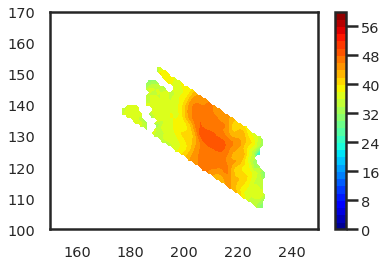

In [39]:
plt.contourf(np.ma.masked_array(deepcopy(base.fields['reflectivity']['data'][3,:,:]),
                                mask=np.logical_not(mask),fill_value=np.nan),levels=np.linspace(0,60,31),cmap='jet')
plt.colorbar()
plt.xlim(150,250)
plt.ylim(100,170)
plt.show()